Project image sequence colorization 

LACHOUQUE Jacques
KOÏTA Adama


In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
import os

In [4]:
%matplotlib inline

import numpy as np # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 as cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting
import numpy.random 
# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


In [5]:
def imshow_plt(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional

    
def imshow_cv(image, cmap=None):
  plt.imshow(image, cmap)
  plt.show()

(557, 362, 3)


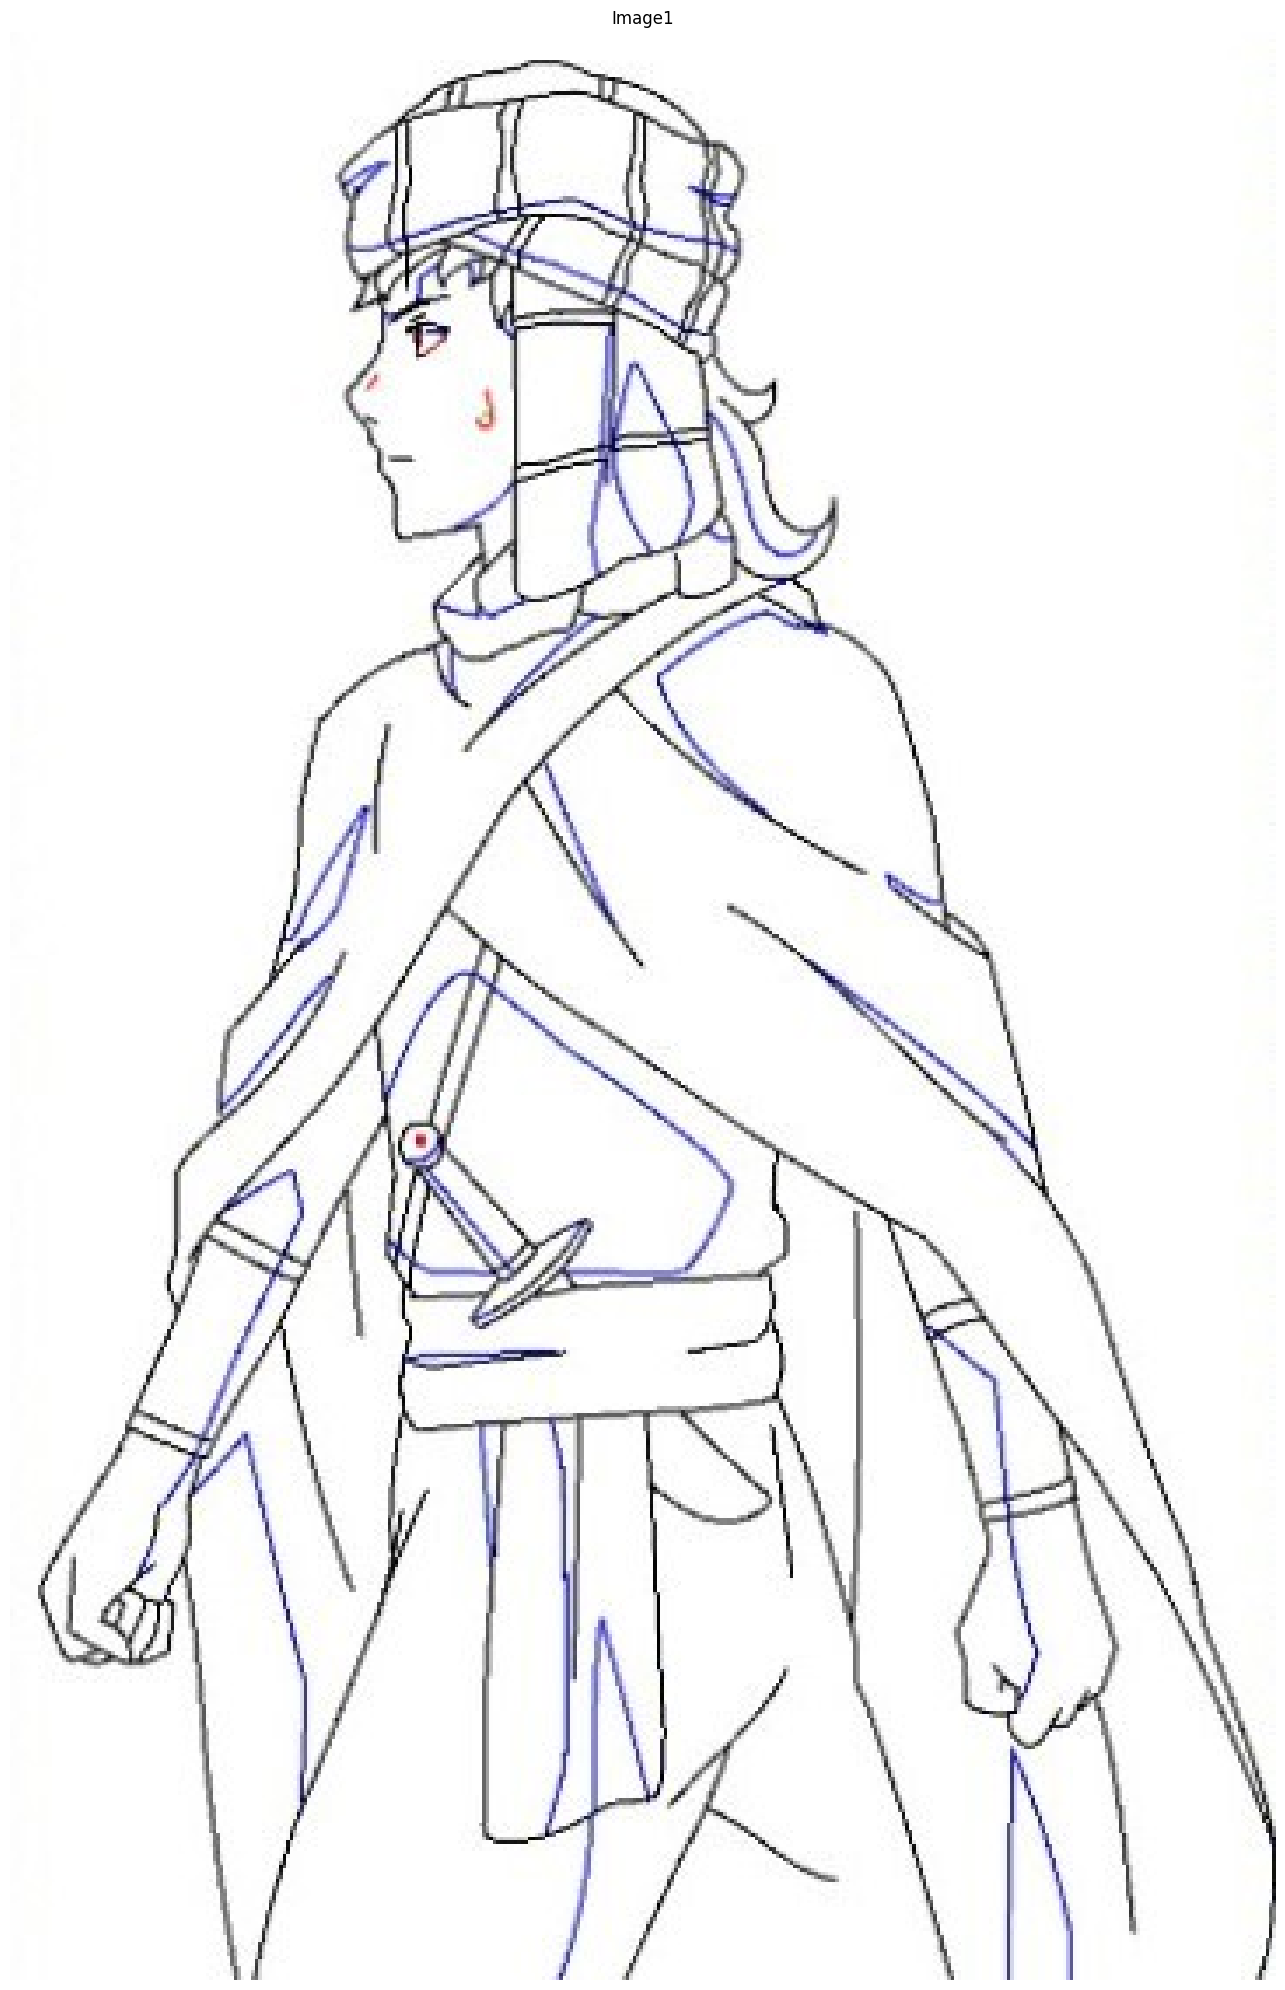

In [6]:
myimage = io.imread("dataset/sketch/1.jpg")
imshow_plt( [myimage], ['Image1'])
print(myimage.shape)

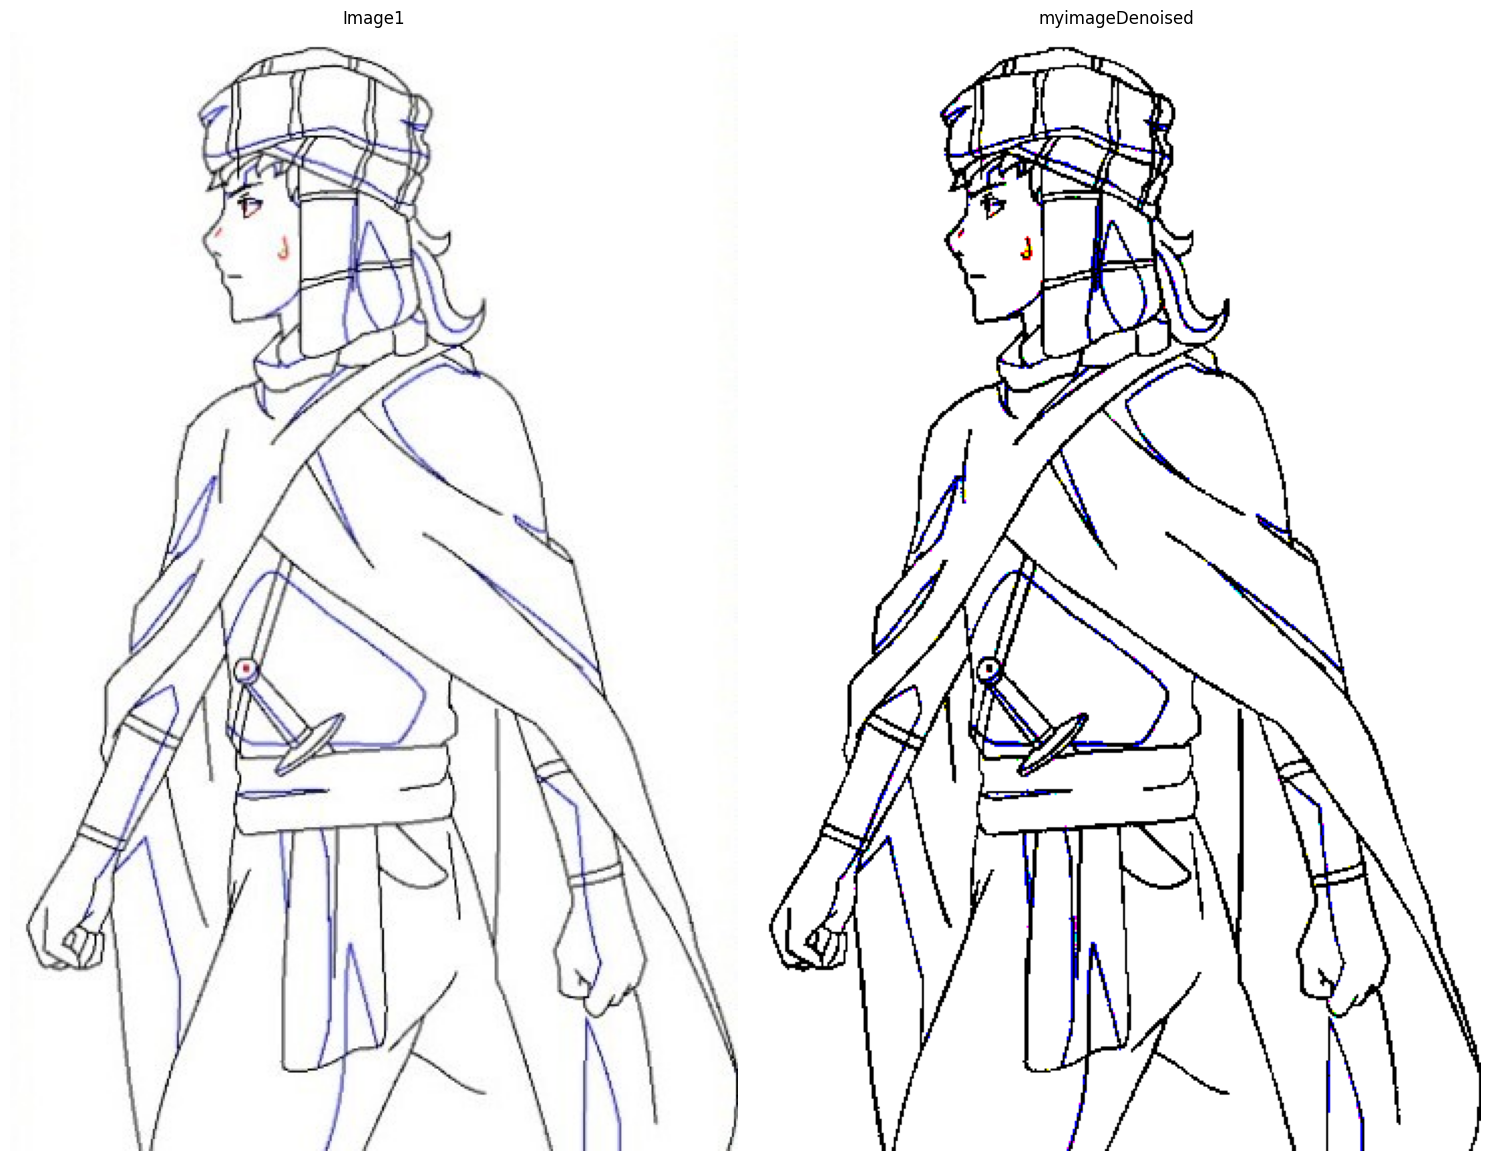

In [7]:
def threshold(img, value):
   """
   Delete noise and highligh the contours
   parameters:
      image : np.ndarray 
         image to denoise
      value : int
         treshold value of the pixel color
   returns:
      image denoised
   """
   return np.where(img <= value, 0, 255)



myimage_denoised = threshold(myimage,200)

imshow_plt( [myimage, myimage_denoised], ['Image1', 'myimageDenoised'])


In [8]:
def classes_matrix_to_image(classes_matrix, list_class):
    image = np.zeros((classes_matrix.shape[0],classes_matrix.shape[1],3), dtype=int)
    for c in list_class:
        mask = (classes_matrix == c)
        random_color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
        image[mask] = random_color
        #print("class "+ str(c)+" color:",random_color)
    return image


def filling(i,j,classes_matrix,treated_pixels, class_num ):
    #private function
    stack = [(i,j)] #utilisation de stack car probleme avec la recursion

    while stack :
        x,y = stack.pop()
        if(classes_matrix[x][y] == 0):
            classes_matrix[x][y] = class_num
            treated_pixels[x][y] = True
            if(x != 0):
                #classes_matrix = filling(x-1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x - 1, y))
            if(x != classes_matrix.shape[0]-1):
                #classes_matrix =filling(x+1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x + 1, y))
            if(y != 0):
                #classes_matrix =filling(x,y-1,classes_matrix,treated_pixels, class_num)
                stack.append((x, y - 1))
            if(y != classes_matrix.shape[1]-1):
                #classes_matrix =filling(x,y+1,classes_matrix,treated_pixels, class_num)
                stack.append((x , y+ 1))
    return classes_matrix



def assign_class_to_pixel_by_filling(image):


    #create matrix of classes
    classes_matrix = np.zeros((image.shape[0], image.shape[1]))
    classes_matrix =  np.where(
    (image[..., 0] == 255) & 
    (image[..., 1] == 255) & 
    (image[..., 2] == 255),
    classes_matrix, -1)
   
    print(classes_matrix.shape)
    #imshow_cv(classes_matrix)
    
    last_class = 1
    classes_num_list = [1]
    treated_pixels = np.full_like(classes_matrix, False, dtype=bool)

    mask_contour = (classes_matrix == -1) # -1 is the value of contours 
    treated_pixels[mask_contour] = True        
    while(np.isin(classes_matrix,0).any()):
        #classes_matrix, new_treated_pixels = apply_class_in_matrix(classes_matrix, treated_pixels,last_class)
        #treated_pixels = new_treated_pixels.copy()
        fill = False
        for line in range(classes_matrix.shape[0]):
            for col in range(classes_matrix.shape[1]):#parcourir de la gauche 
                if(classes_matrix[line][col] == 0):
                    filling(line, col,classes_matrix, treated_pixels,last_class)
                    fill =True

                    break
            if(fill): break  
        last_class+=1
        classes_num_list.append(last_class)


    return classes_matrix, classes_num_list


filling with denoised image
(557, 362)


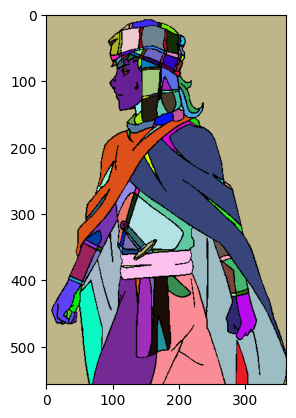

In [9]:

print("filling with denoised image")
classes_matrix_image_denoised, classes_num_list_image_denoised = assign_class_to_pixel_by_filling(myimage_denoised)
imshow_cv(classes_matrix_to_image(classes_matrix_image_denoised, classes_num_list_image_denoised))

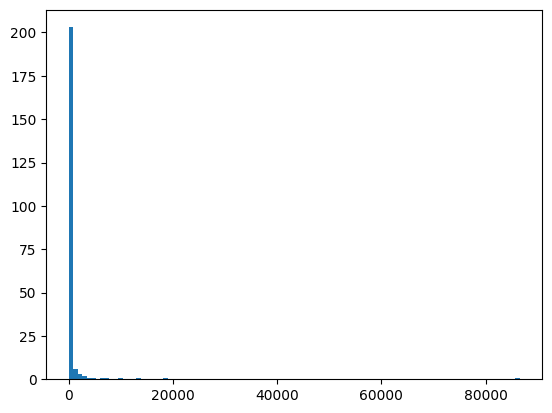

In [10]:
# Count the number of pixels in each class
def count_pixels_in_classes(classes_matrix, classes_num_list):
    counts = []
    for c in classes_num_list:
        counts.append(np.sum(classes_matrix == c))
    return counts
# do a histogram of the number of pixels in each class
def plot_histogram(counts):
    plt.hist(counts, bins=100)
    plt.show()
counts_image_denoised = count_pixels_in_classes(classes_matrix_image_denoised, classes_num_list_image_denoised) 
plot_histogram(counts_image_denoised)

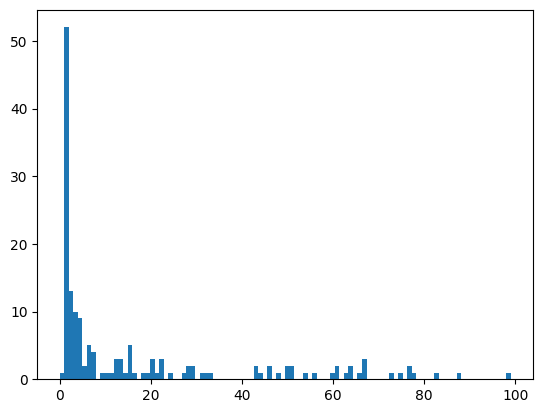

threshold  [1, 3, 5, 10, 20, 50]


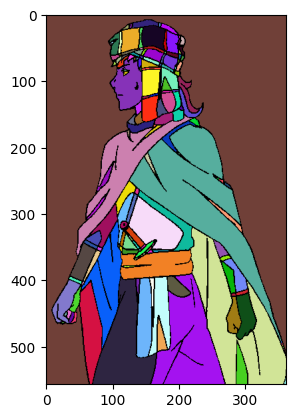

threshold  [1, 3, 5, 10, 20, 50]


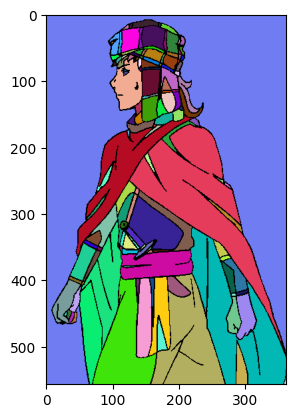

threshold  [1, 3, 5, 10, 20, 50]


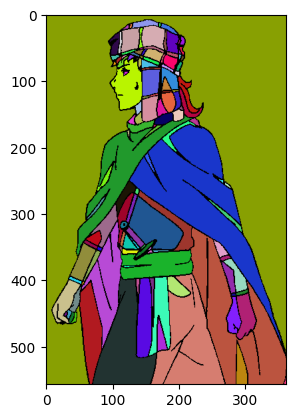

threshold  [1, 3, 5, 10, 20, 50]


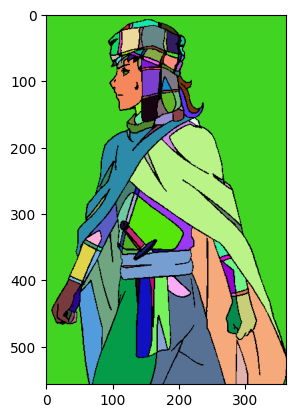

threshold  [1, 3, 5, 10, 20, 50]


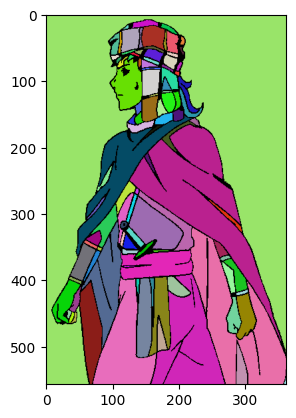

threshold  [1, 3, 5, 10, 20, 50]


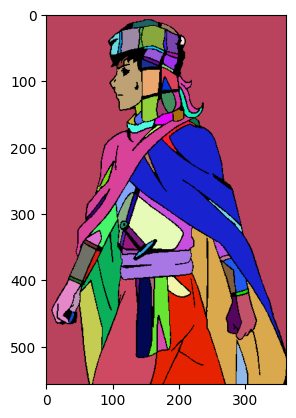

Number of classes with less than 10 pixels in the denoised image 97


In [11]:
# show the histogram of the number of pixels in each class only for the classes with less than 100 pixels
def plot_histogram_small_classes(counts):
    plt.hist([c for c in counts if c < 100], bins=100)
    plt.show()
plot_histogram_small_classes(counts_image_denoised)
#filter the classes with less than a threshold of pixels
t_list = [1,3,5,10,20,50]
# show the image with the classes with a higher number of pixels than the threshold
def filter_classes(classes_matrix, classes_num_list, t_list):
    for t in t_list:
        print("threshold ",t_list)
        mask = np.isin(classes_matrix, [c for c in classes_num_list if np.sum(classes_matrix == c) > t])
        imshow_cv(classes_matrix_to_image(classes_matrix, [c for c in classes_num_list if np.sum(classes_matrix == c) > t]))

filter_classes(classes_matrix_image_denoised, classes_num_list_image_denoised, t_list)
# Number of classes with less than 10 pixels 
def count_small_classes(counts, t):
    return len([c for c in counts if c < t])
print("Number of classes with less than 10 pixels in the denoised image", count_small_classes(counts_image_denoised, 10))

In [12]:
# Number of classes with less than 10 pixels 
def count_small_classes(counts, t):
    return len([c for c in counts if c < t])    
print("Number of classes with less than 10 pixels in the denoised image", count_small_classes(counts_image_denoised, 10))

Number of classes with less than 10 pixels in the denoised image 97


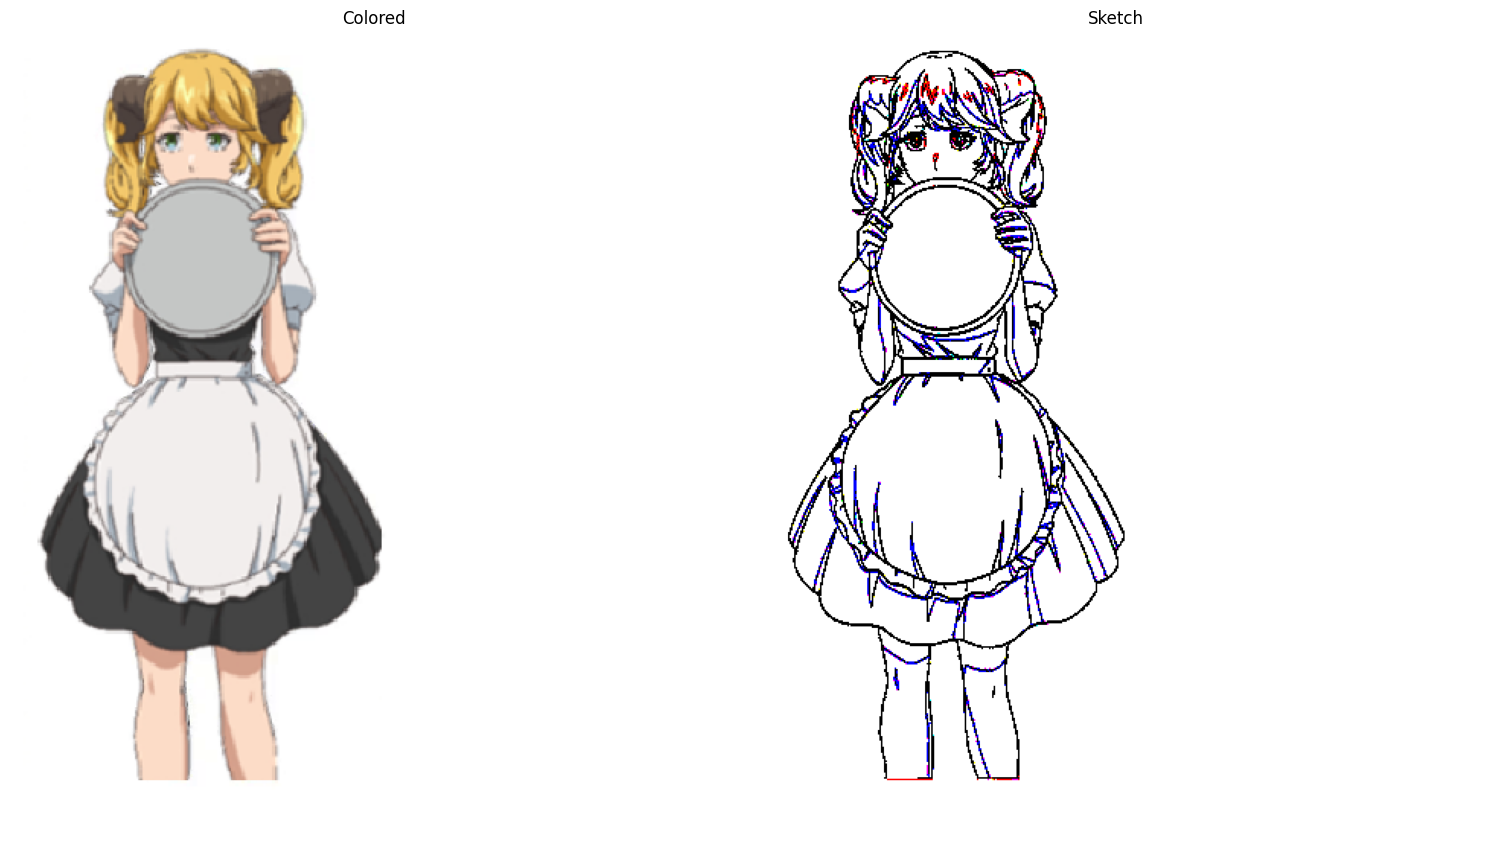

In [13]:
image_references = io.imread("dataset/colored/sequence1/1.png")
images= [image_references,threshold(io.imread("dataset/sketch/sequence1/1.png"),220)]
imshow_plt( images, ['Colored', 'Sketch'])


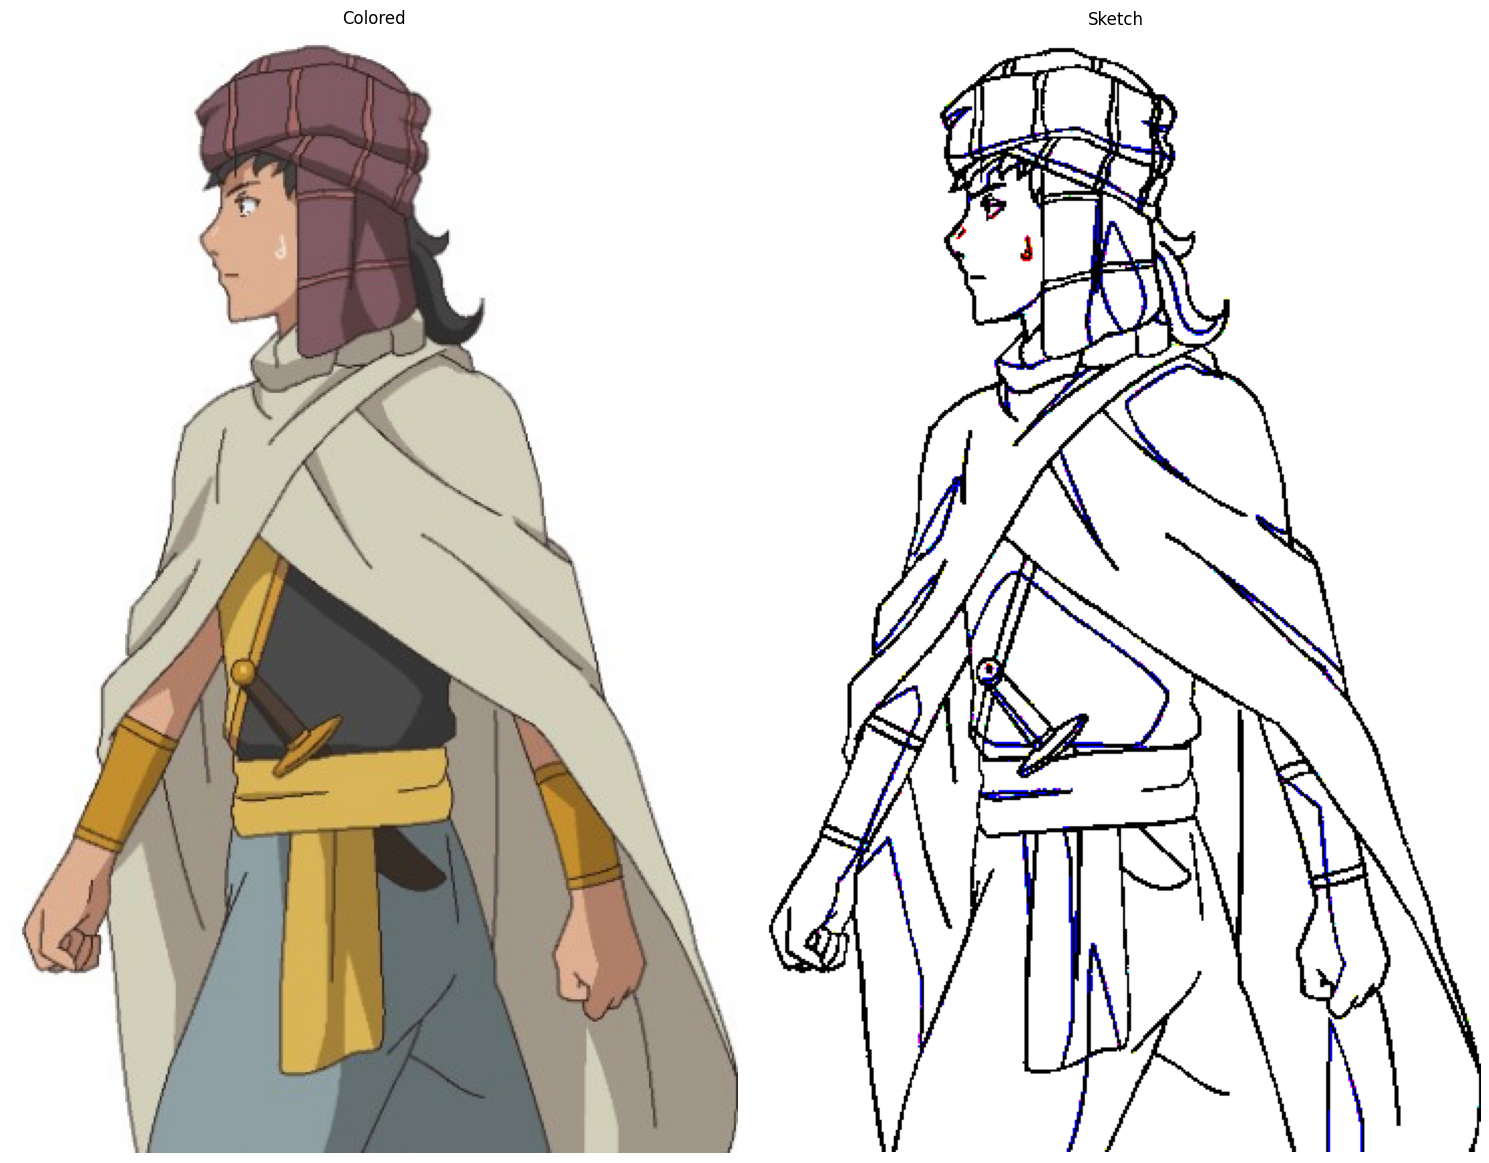

In [14]:
image_references = io.imread("dataset/colored/sequence3/1.jpg")
images= [image_references,threshold(io.imread("dataset/sketch/sequence3/01.jpg"),220)]
imshow_plt( images, ['Colored', 'Sketch'])

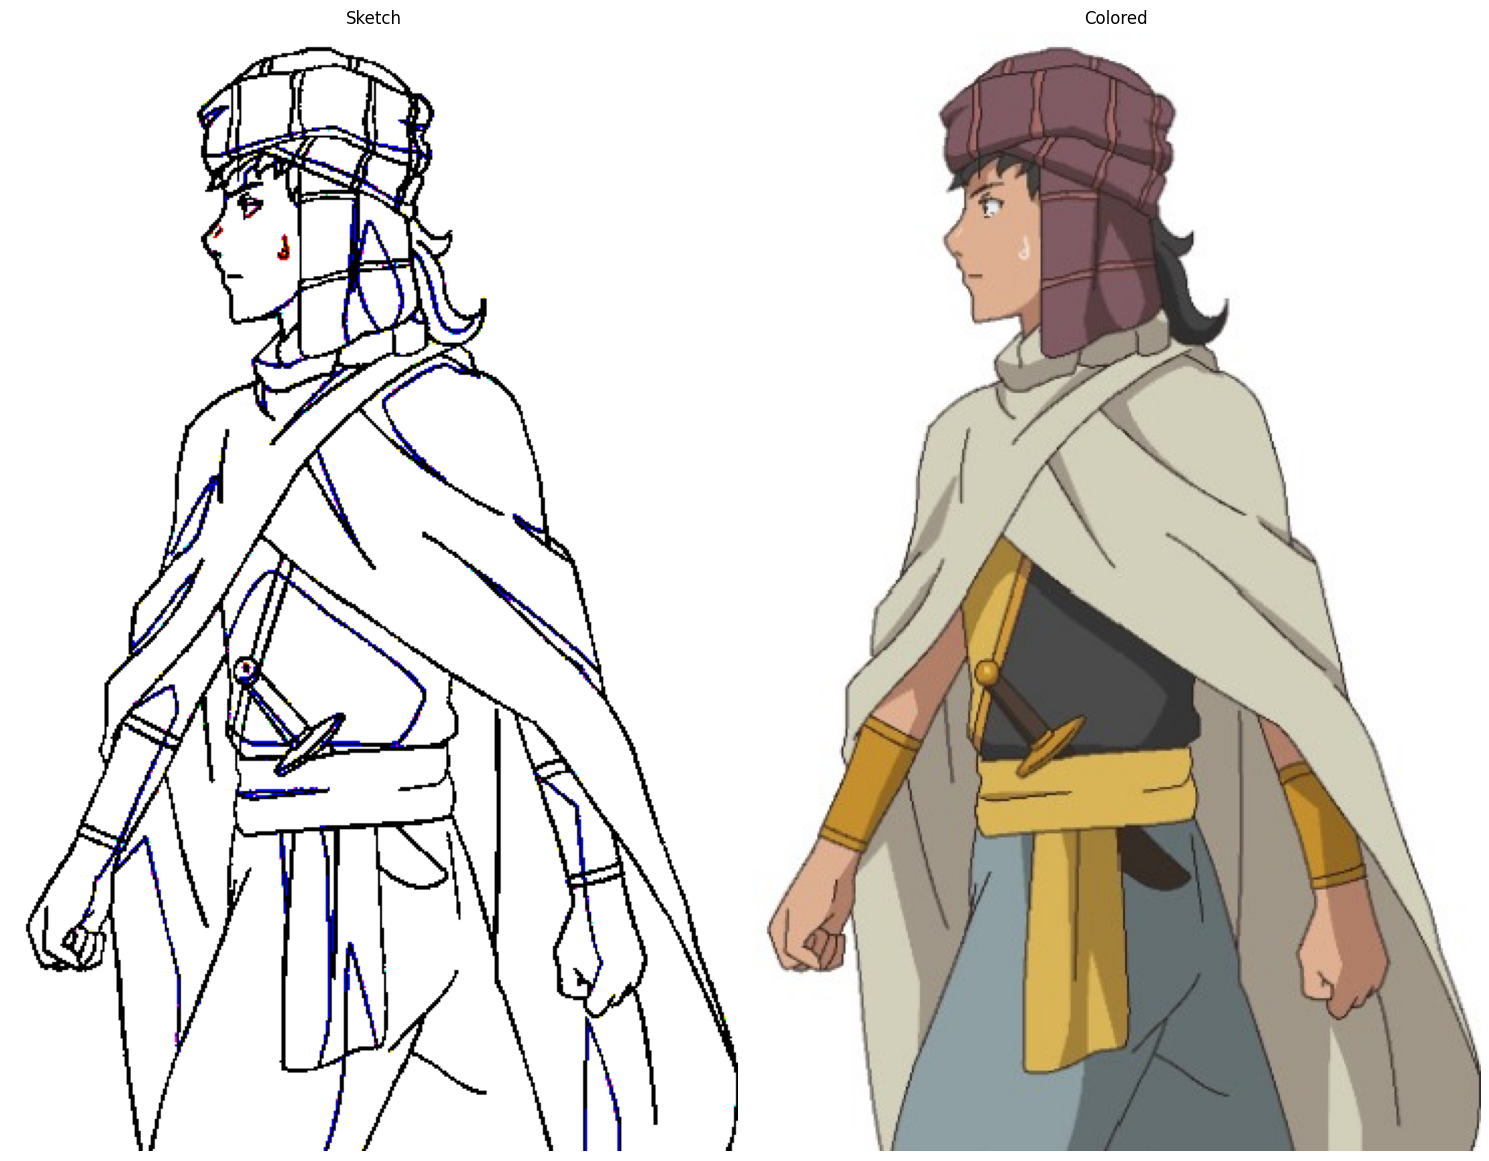

In [16]:
#Reshape the image to have the same size
def reshape_image(image, reference):
    return cv2.resize(image, (reference.shape[1], reference.shape[0]), interpolation = cv2.INTER_NEAREST)

image_references = io.imread("dataset/sketch/sequence3/01.jpg")
image_references = threshold(image_references,220)
image= io.imread("dataset/colored/sequence3/1.jpg")
image = reshape_image(image, image_references)
images= [image_references,image]
imshow_plt( images, ['Sketch', 'Colored'])

(557, 362)
Apply pixel from previous to new


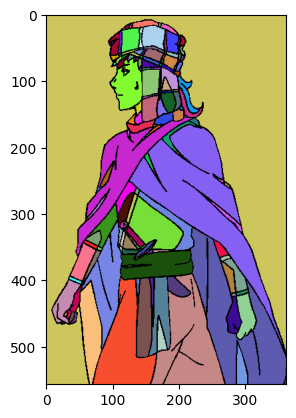

In [17]:
#color first image 
classes_matrix , classes_num_list = assign_class_to_pixel_by_filling(image_references)
image_colored = classes_matrix_to_image(classes_matrix, classes_num_list)
print('Apply pixel from previous to new')
imshow_cv(image_colored)

In [18]:

from collections import Counter

def assign_color_to_class_from_reference(image_classes, list_classes, image_reference):
    """ 
    This class allows to assign a color to each image class from the reference image
    parameters:
        -image_classes : np.ndarray 
            matrix of the classes associated to each pixel
        - list_classes : list 
            list of classes values
        image_reference : np.ndarray
            colored image reference
    """
    output_image = np.zeros((*image_classes.shape, 3), dtype=int)

    for c in list_classes:
        mask = (image_classes == c)
        indices = np.argwhere(mask)

        if len(indices) > 0:
            colors = [tuple(image_reference[i, j]) for i, j in indices]
            most_common_color = Counter(colors).most_common(1)[0][0]

            # Assigner la couleur trouvée à tous les pixels de la classe
            output_image[mask] = (most_common_color[0], most_common_color[1],most_common_color[2])

    return output_image

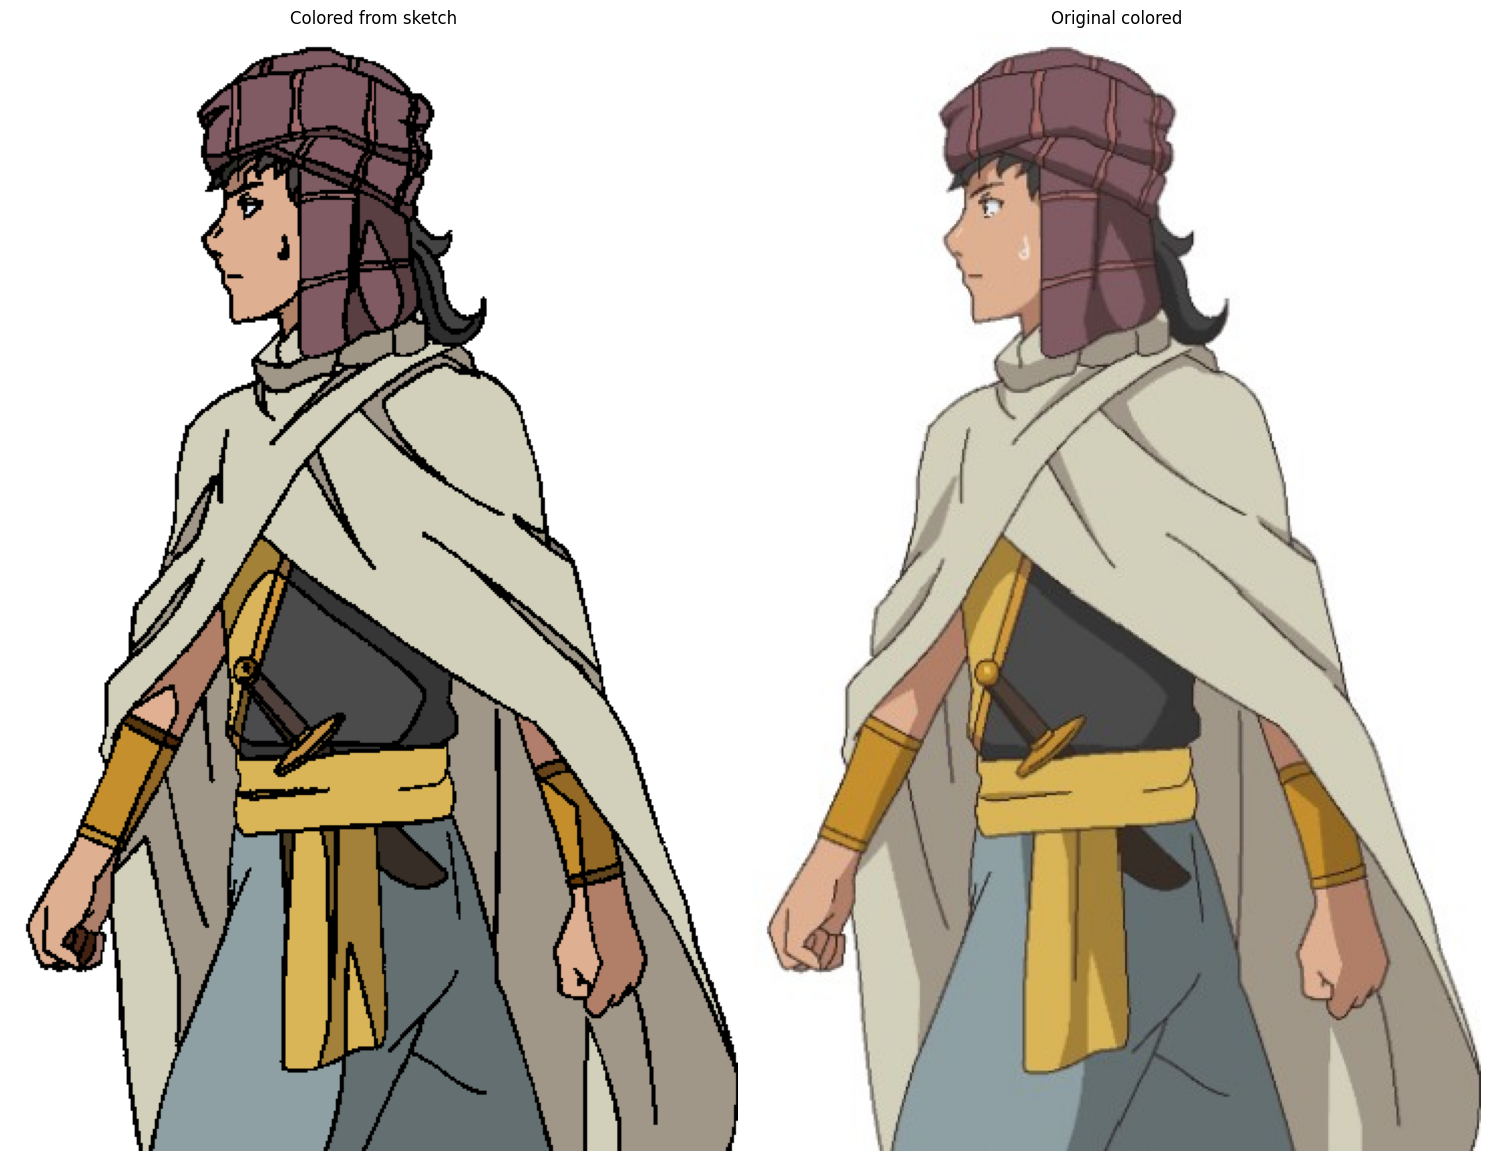

In [22]:
image_color_from_sketch = assign_color_to_class_from_reference(classes_matrix,classes_num_list, image)

imshow_plt([image_color_from_sketch, image],[ 'Colored from sketch', 'Original colored'])

In [24]:
def get_mask_from_class(image_classes, class_num):
    "Create a 0 1 mask for a class"
    return (image_classes == class_num)

def get_mask_from_classes(image_classes, classes_list):
    "Create a 0 1 mask for all classes in the list"
    masks = []
    for c in classes_list:
        masks.append(get_mask_from_class(image_classes, c))
    return masks

In [64]:
def color_transfer_mask(image_1,image_2,image_1_reference):
    """transfer the color from image 1 to image 2
    output: image 2 with the color of image 1
    """
    # Reshape image 2 to have the same size as image 1
    image_2 = reshape_image(image_2, image_1)
    image_1_reference = reshape_image(image_1_reference, image_1)
    # Denoise both images
    image_1 = threshold(image_1, 220)
    image_2 = threshold(image_2, 220)
    imshow_plt([image_1, image_2], ['Image 1', 'Image 2'])
    # Get the classes from both images
    classes_matrix_1, classes_num_list_1 = assign_class_to_pixel_by_filling(image_1)
    classes_matrix_2, classes_num_list_2 = assign_class_to_pixel_by_filling(image_2)
    # print the number of classes in each image
    print("Number of classes in image 1", len(classes_num_list_1))
    print("Number of classes in image 2", len(classes_num_list_2))
    # show the images 
    image_1_color_from_sketch = assign_color_to_class_from_reference(classes_matrix_1,classes_num_list_1, image_1_reference)
    image_2_ramdom_color = classes_matrix_to_image(classes_matrix_2, classes_num_list_2)
    imshow_plt([image_1_color_from_sketch, image_2_ramdom_color], ['Image 1 colored', 'Image 2 colored'])
    # Get the mask for each class in both images
    masks_1 = get_mask_from_classes(classes_matrix_1, classes_num_list_1)
    masks_2 = get_mask_from_classes(classes_matrix_2, classes_num_list_2)
    # Compute the intersection of the masks for each class
    intersection = np.zeros((len(classes_num_list_1), len(classes_num_list_2)))
    for i in range(len(classes_num_list_1)):
        for j in range(len(classes_num_list_2)):
            intersection[i, j] = np.sum(masks_1[i] & masks_2[j])
    # Match the classes between the two images
    matching = np.zeros(len(classes_num_list_2))
    matching = matching - 1
    for i in range(len(classes_num_list_2)):
        temp_max = np.max(intersection)
        if temp_max == 0:
            break
        #get the index of the max value
        index_max = np.unravel_index(np.argmax(intersection, axis=None), intersection.shape)
        matching[index_max[1]] = index_max[0]+1
        # replace the line and the column of the max value by 0
        intersection[index_max[0], :] = 0
        intersection[:, index_max[1]] = 0
    image_2_color_from_matching = color_image_from_matching(matching, classes_matrix_2, classes_num_list_2, image_1_color_from_sketch, classes_matrix_1, classes_num_list_1)
    imshow_plt([image_1_color_from_sketch, image_2_color_from_matching], ['Image 1 colored', 'Image 2 colored'])

def color_image_from_matching(matching, classes_matrix_2, classes_num_list_2, image_1_color_from_sketch, classes_matrix_1, classes_num_list_1):
    """ Color the image 2 from the matching of the classes between image 1 and image 2
    """
    image_2_color_from_matching = np.zeros((*classes_matrix_2.shape, 3), dtype=int)
    for i in range(len(matching)):
        if matching[i] != -1:
            mask = (classes_matrix_2 == i+1)
            # get the color of the class in image 1
            #get the first pixel of the class in image 1
            pixel = np.argwhere(classes_matrix_1 == matching[i])[0]
            color = image_1_color_from_sketch[pixel[0], pixel[1]]
            image_2_color_from_matching[mask] = (color[0], color[1], color[2])
    return(image_2_color_from_matching)


(557, 362)
(557, 362)
Number of classes in image 1 238
Number of classes in image 2 242


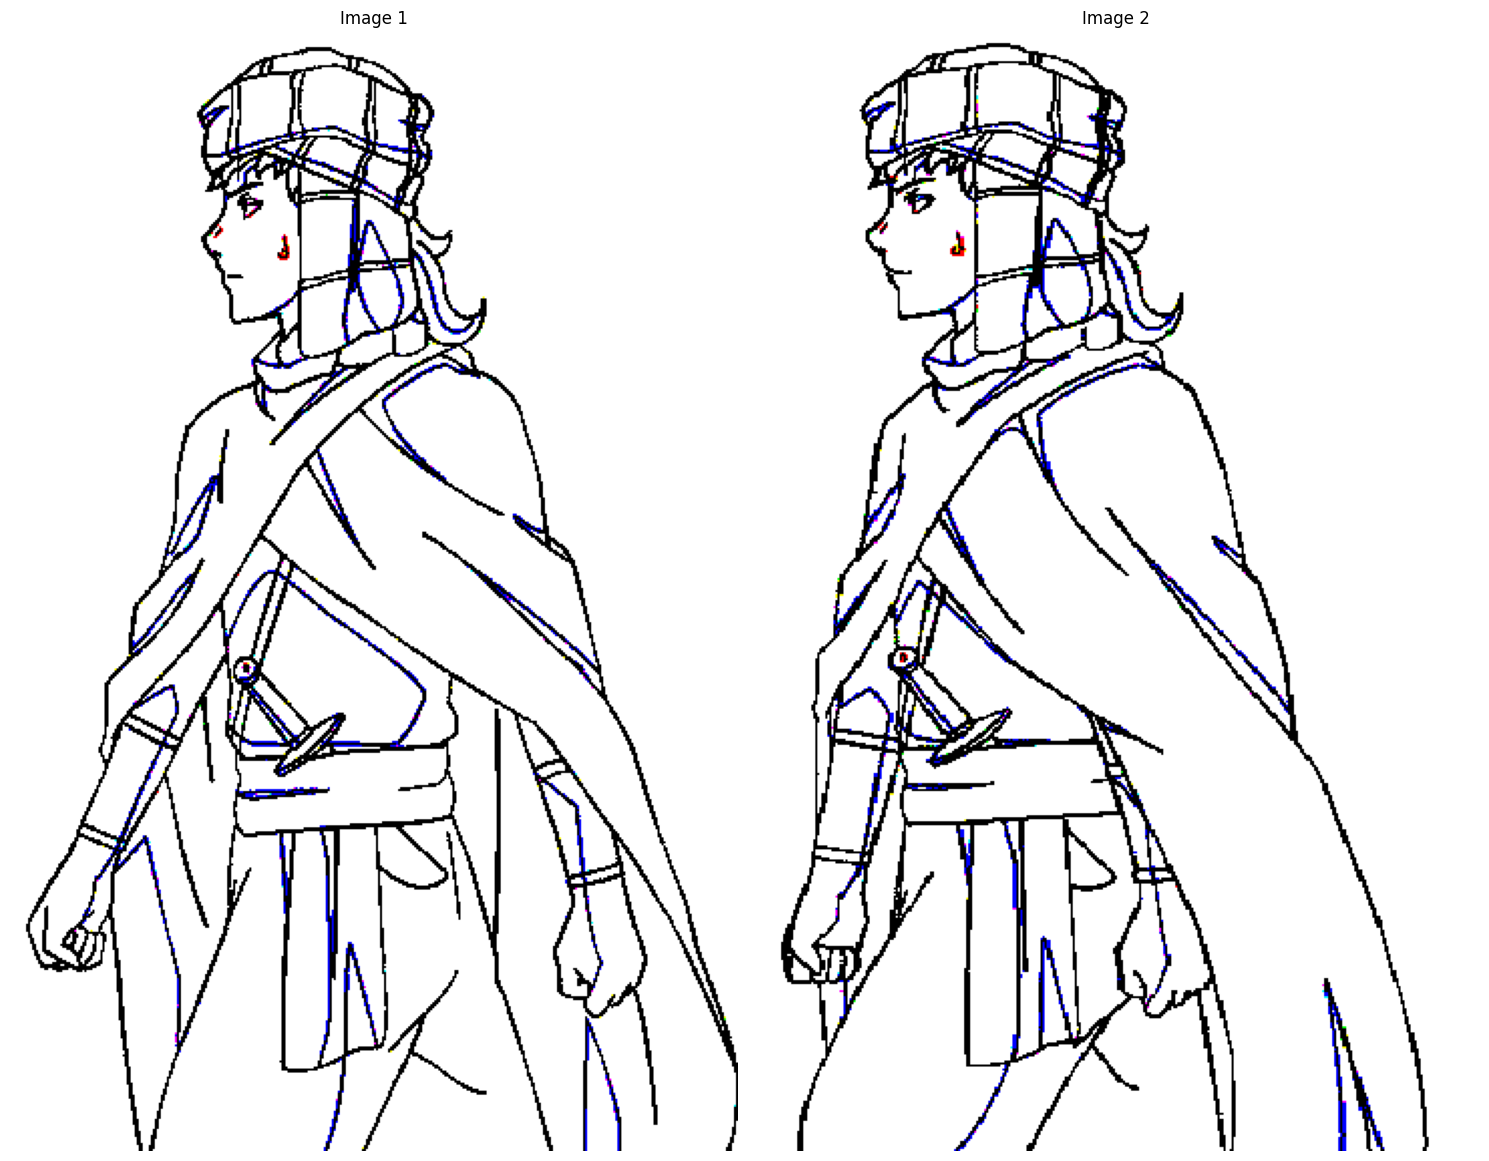

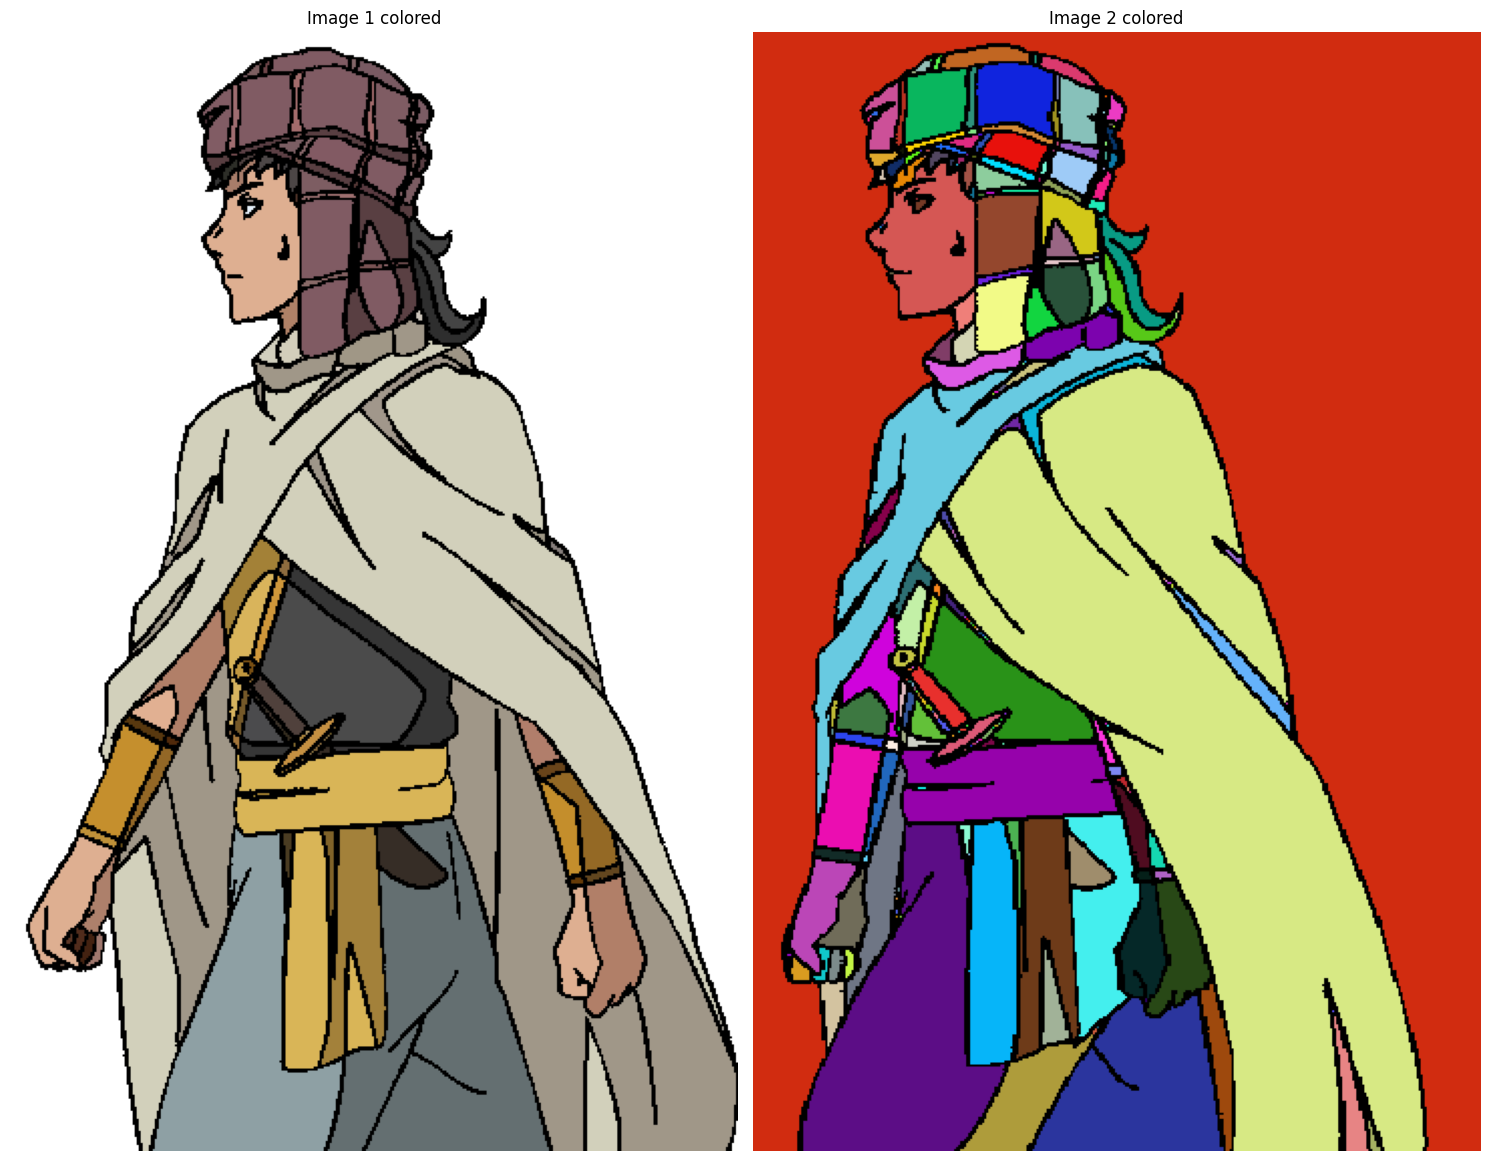

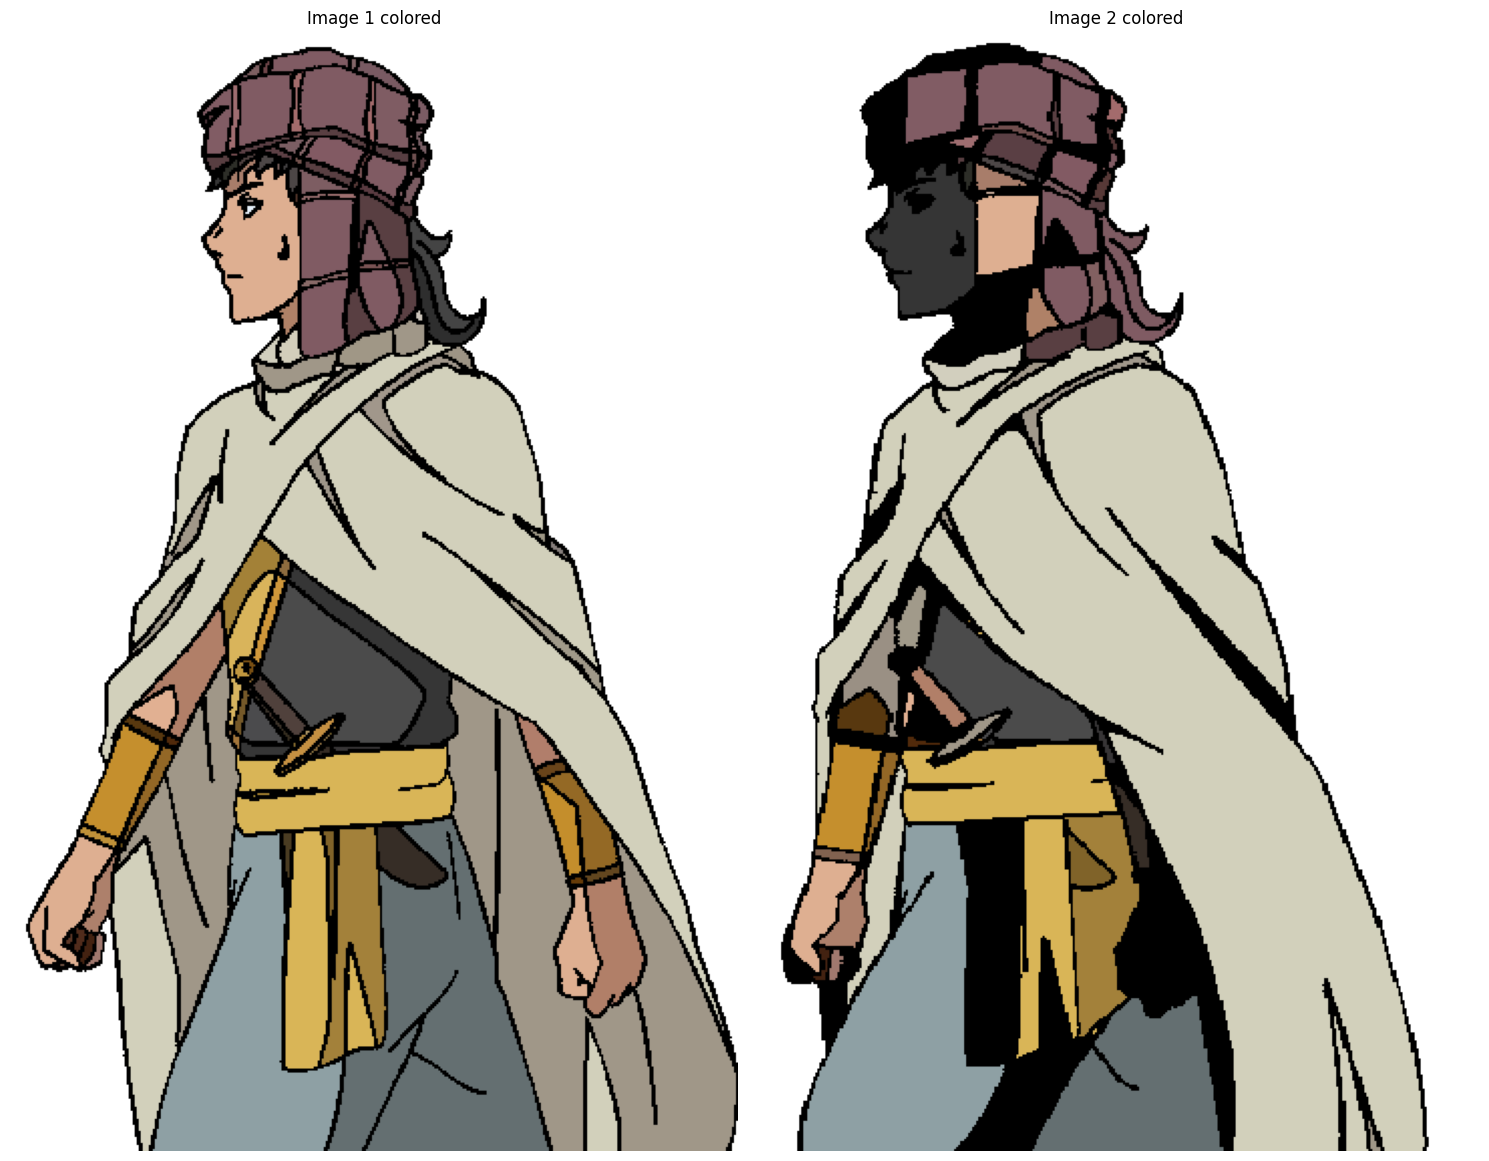

In [65]:
# Test of the color transfer function
image_1 = io.imread("dataset/sketch/sequence3/01.jpg")
image_2 = io.imread("dataset/sketch/sequence3/02.jpg")
image_1_reference = io.imread("dataset/colored/sequence3/1.jpg")
"""
#reshape image 2
image_2 = reshape_image(image_2, image_1)
#threshold image 2
image_2 = threshold(image_2, 220)
#get the classes of the image 2
classes_matrix_2, classes_num_list_2 = assign_class_to_pixel_by_filling(image_2)
#apply color to image 2
image_2_random_color = classes_matrix_to_image(classes_matrix_2, classes_num_list_2)
imshow_cv(image_2_random_color)"""

color_transfer_mask(image_1, image_2, image_1_reference)

(526, 478)
(526, 478)
Number of classes in image 1 375
Number of classes in image 2 381


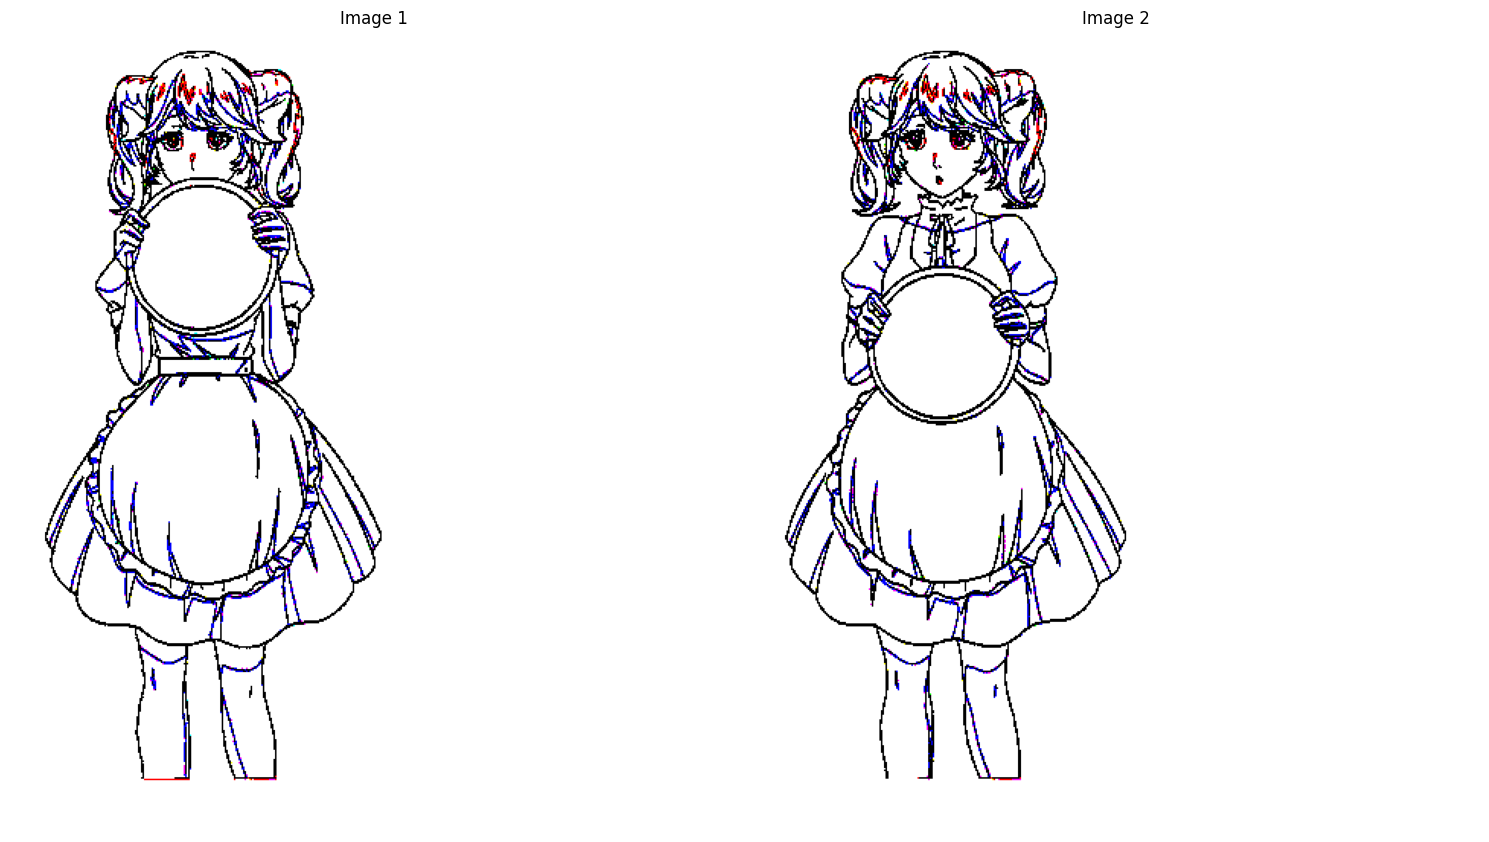

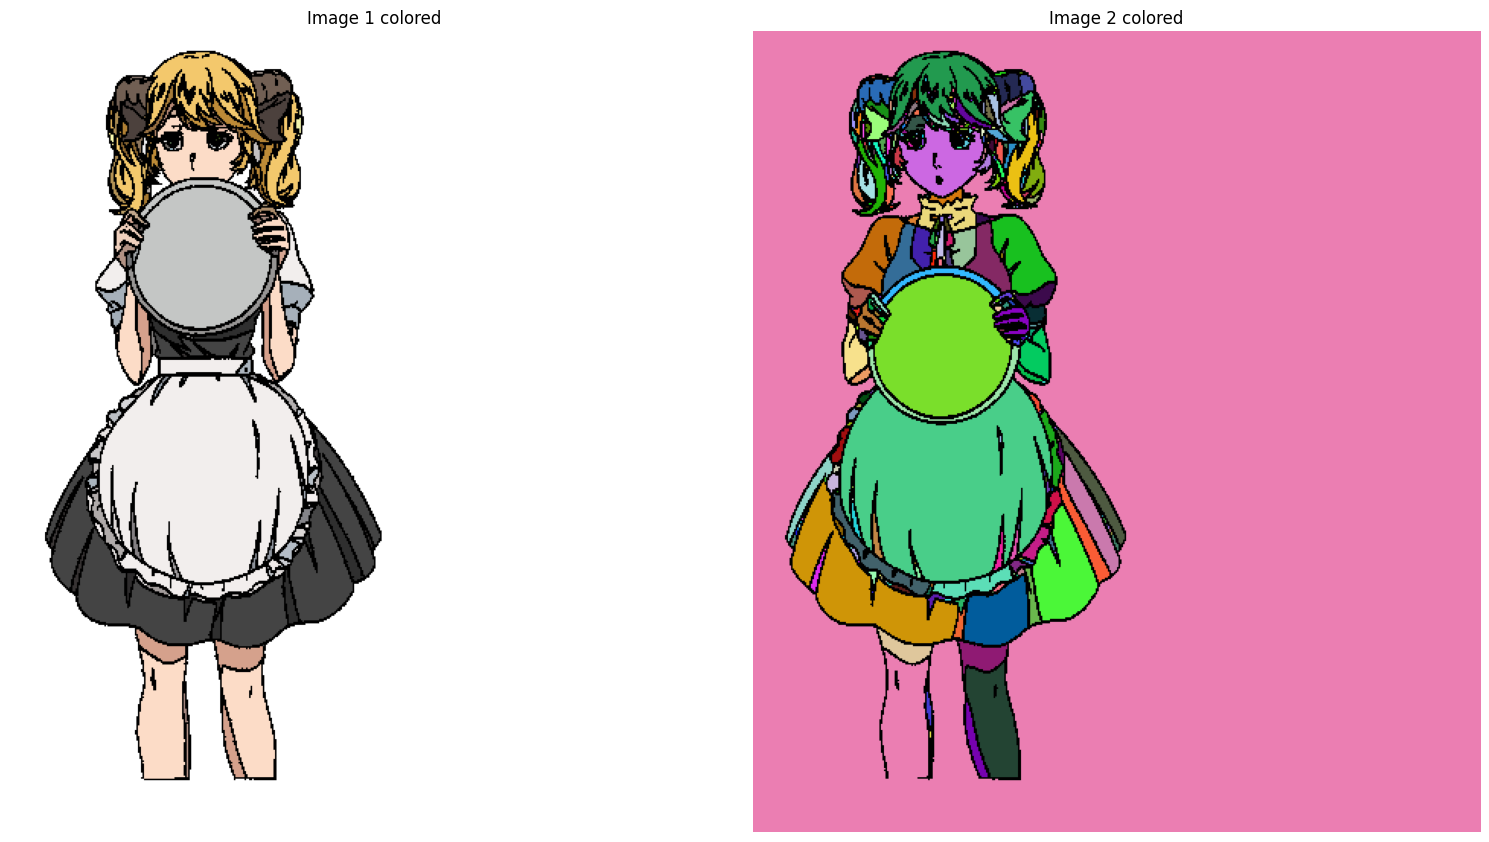

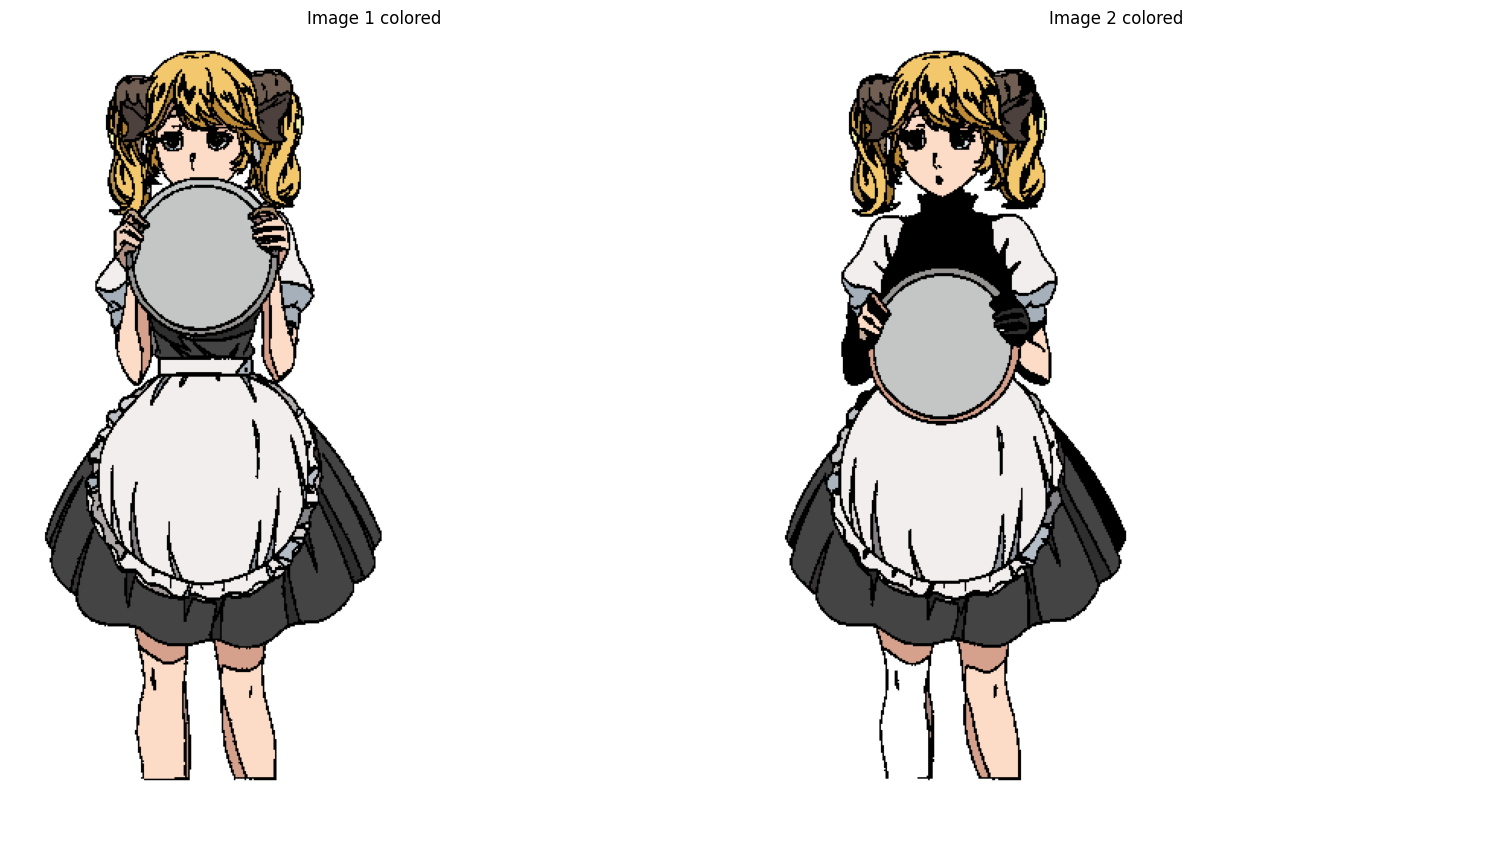

In [66]:
# Test for another image
image_1 = io.imread("dataset/sketch/sequence1/1.png")
image_2 = io.imread("dataset/sketch/sequence1/4.png")
image_1_reference = io.imread("dataset/colored/sequence1/1.png")
color_transfer_mask(image_1, image_2, image_1_reference)

(557, 289)
(557, 289)
Number of classes in image 1 184
Number of classes in image 2 188


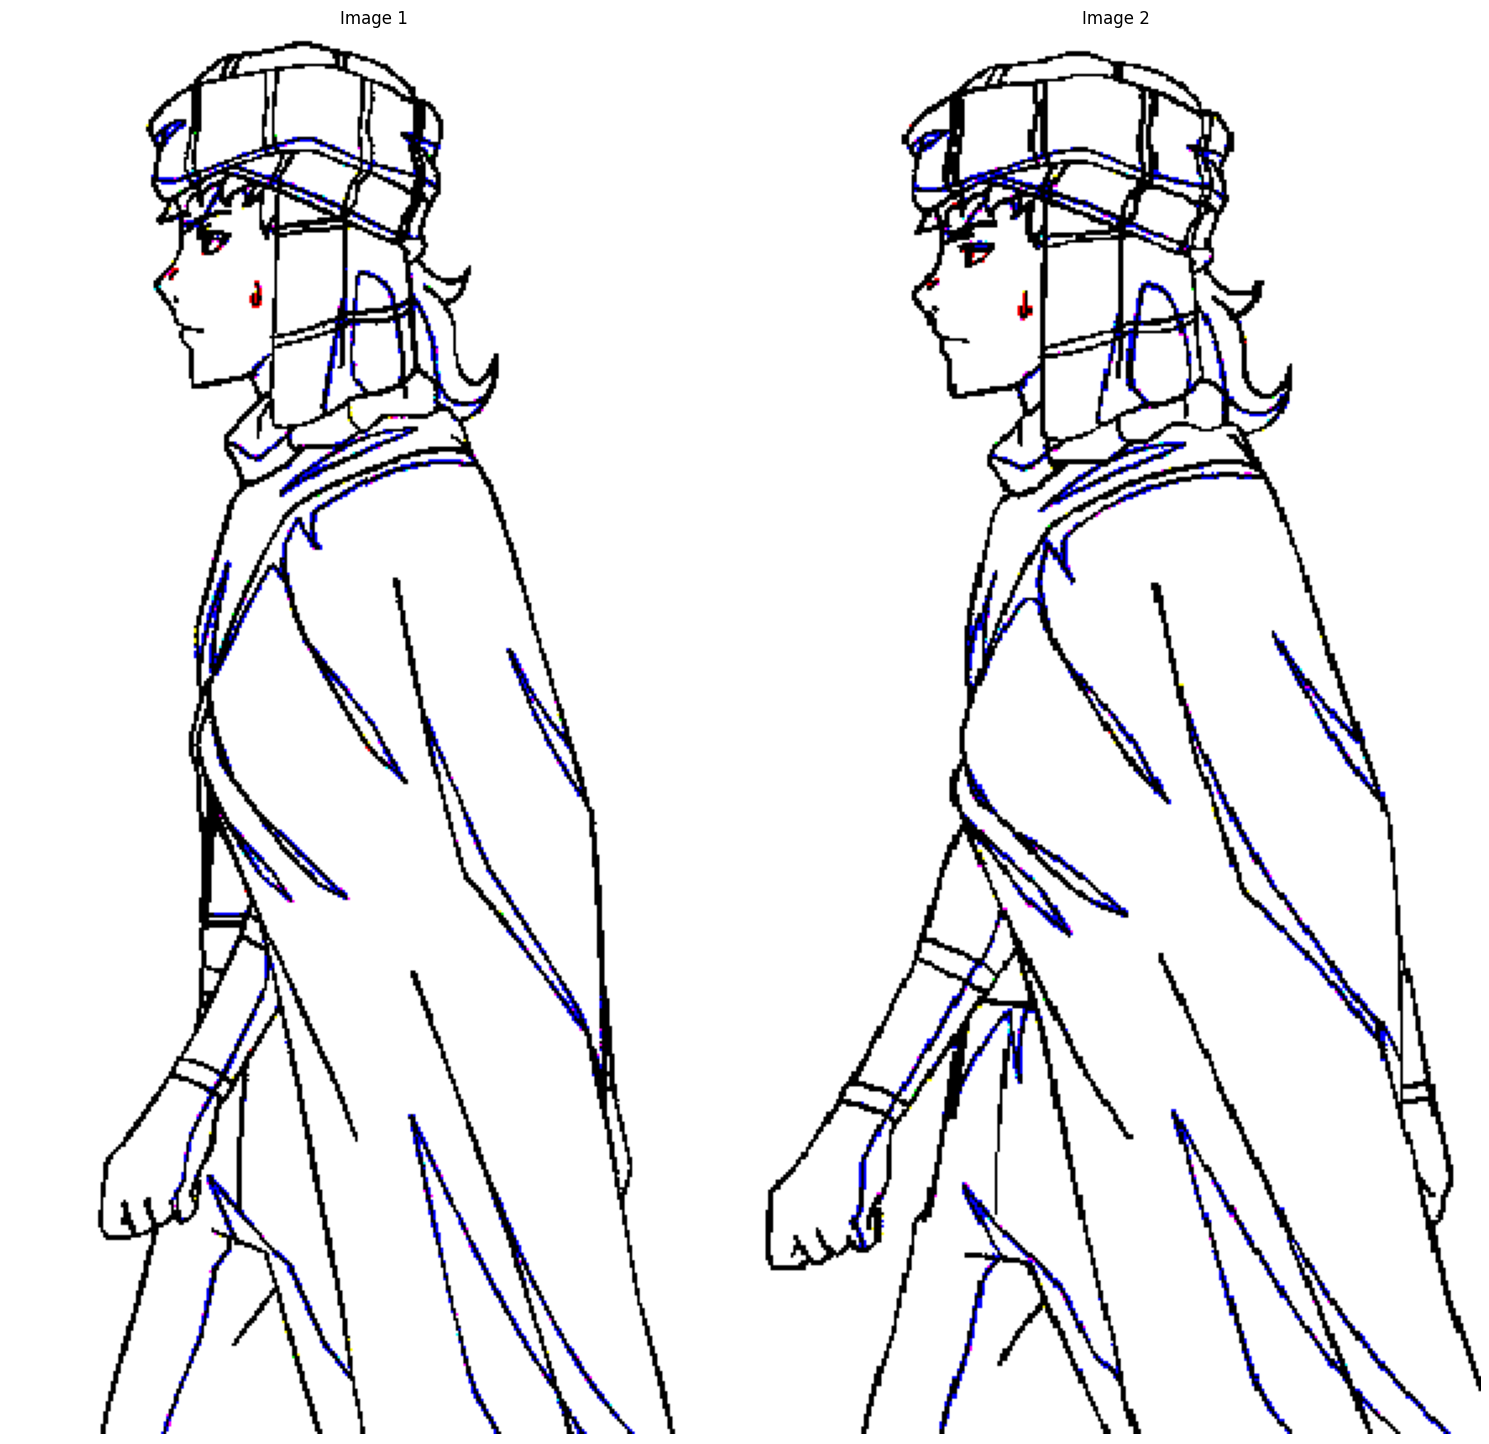

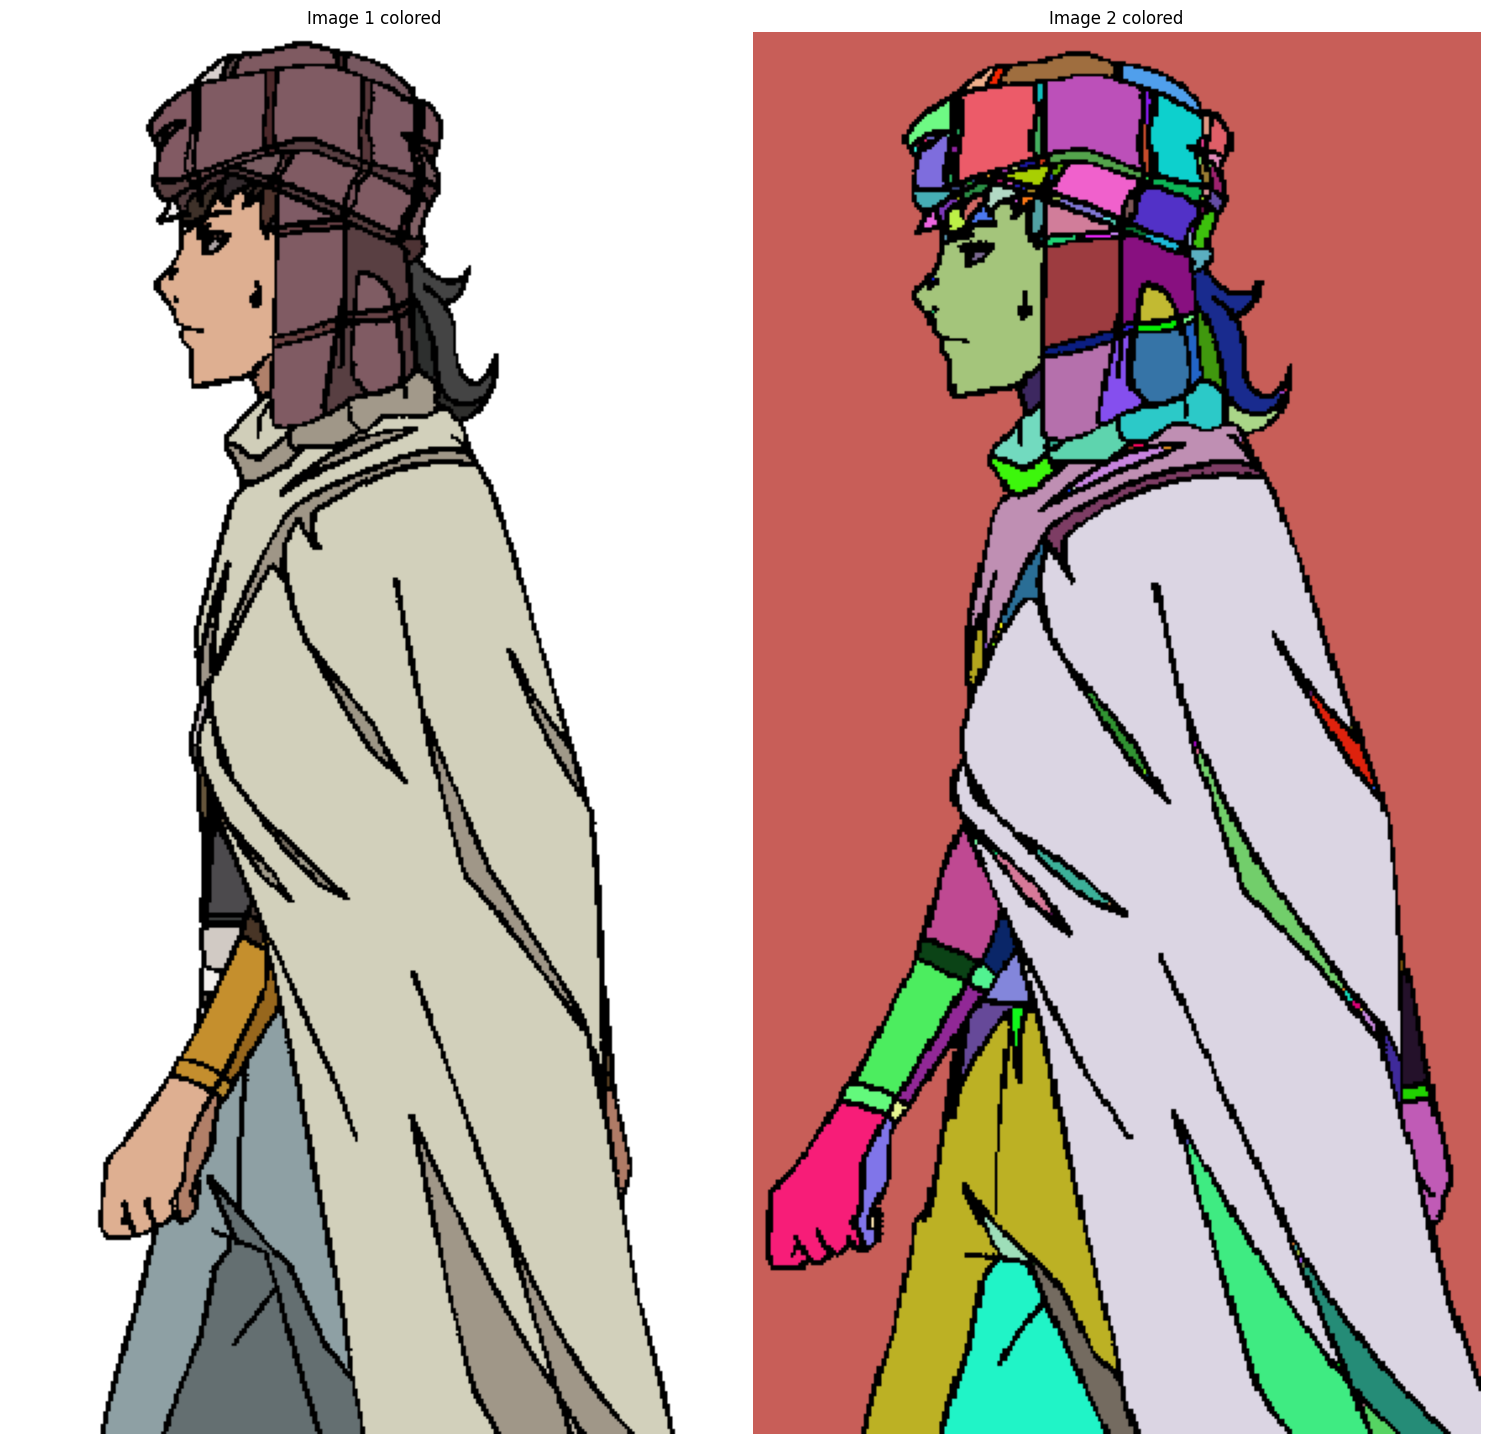

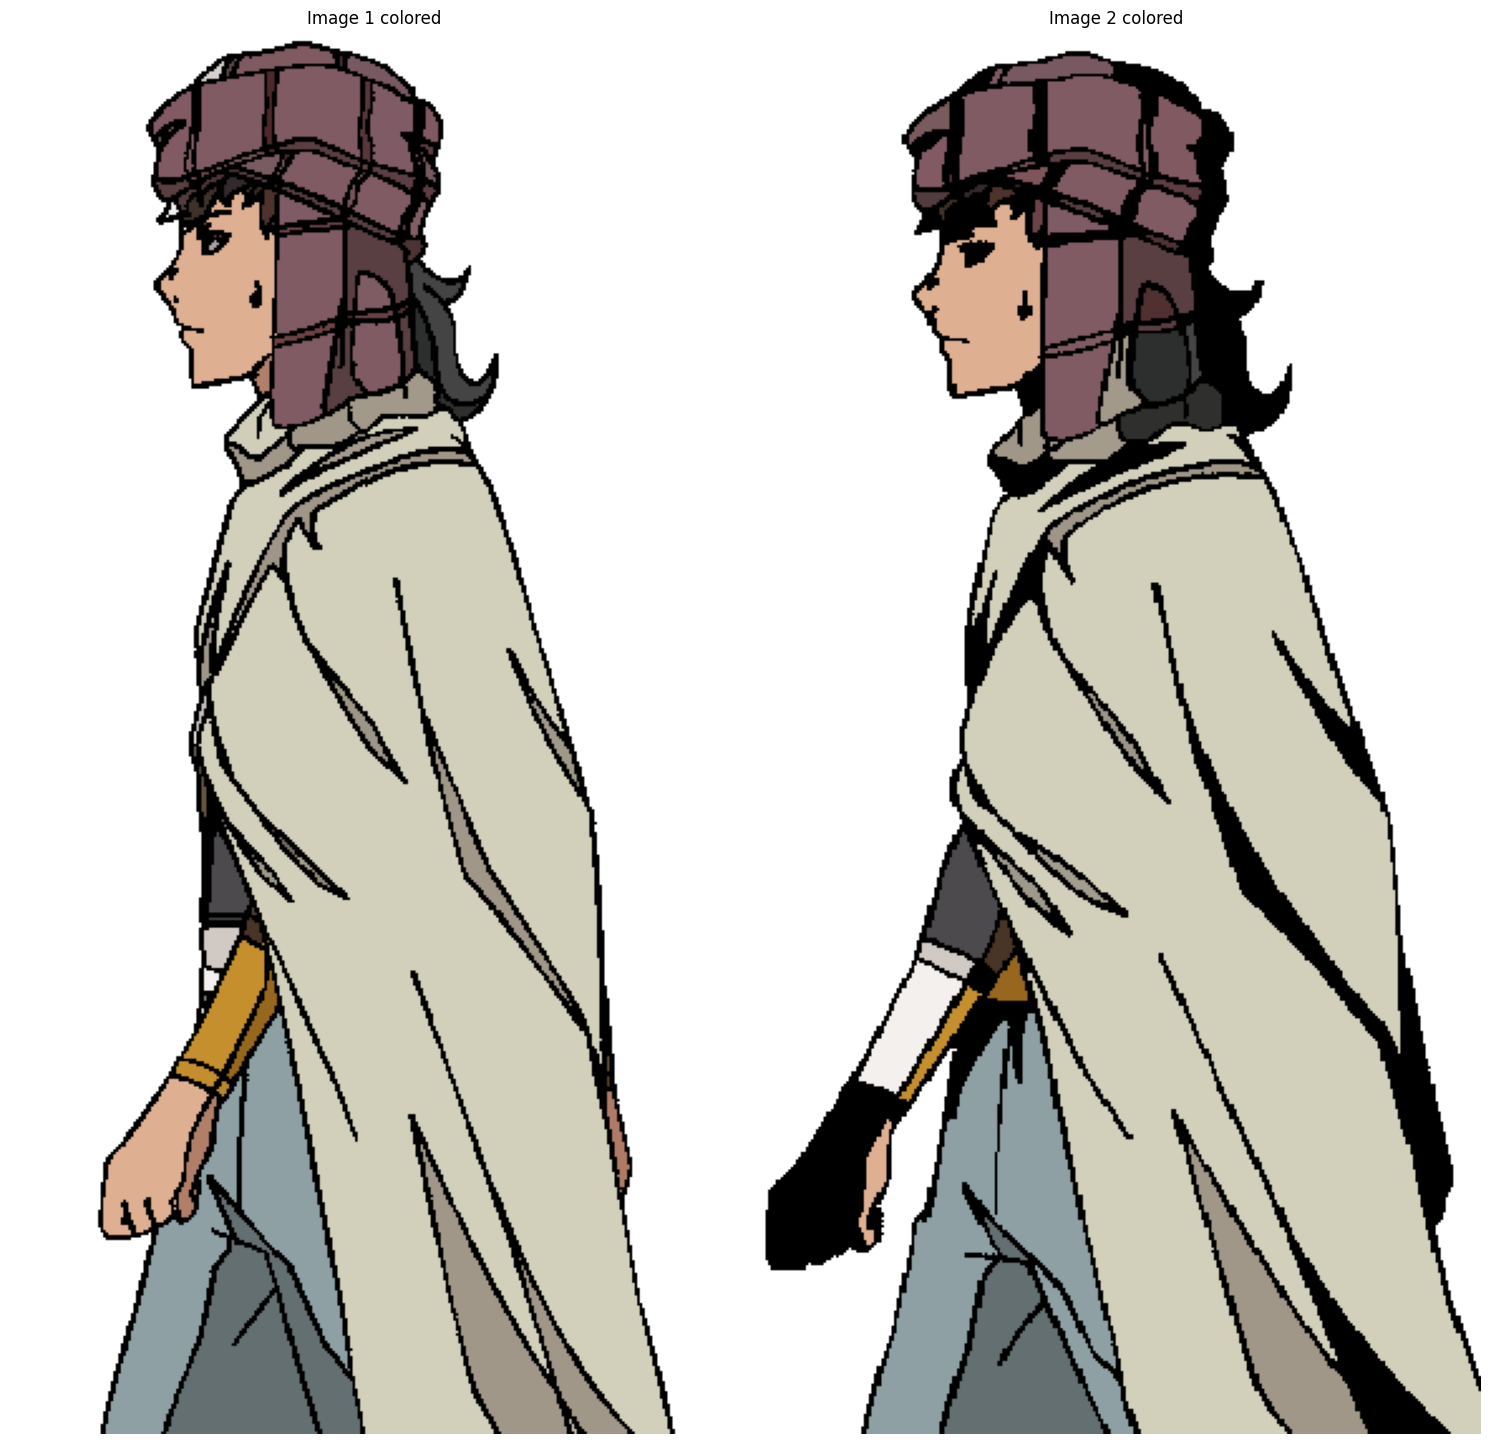

In [68]:
# testing back propagation
image_1 = io.imread("dataset/sketch/sequence3/07.jpg")
image_2 = io.imread("dataset/sketch/sequence3/06.jpg")
image_1_reference = io.imread("dataset/colored/sequence3/7.jpg")

color_transfer_mask(image_1, image_2, image_1_reference)